# Monthly Utility (Electricity) Bill Prediction

Programming Language: R 3.6.1 in Jupyter Notebook

R Libraries used:
- car
- caret
- corrplot
- glmnet
- leaps
- Metrics
- tidyverse

## Table of Contents

1. [Introduction](#sec_1)
2. [Methodology](#sec_2)
- A. [Exploratory Data Analysis](#sec_3)
- B. [Model Development and Model Selection](#sec_4)
3. [Results and Discussion](#sec_5)
4. [Conclusion](#sec_6)
5. [References](#sec_7)

## 1. Introduction <a class="anchor" id="sec_1"></a>

In order to promote energy efficiency and affordability, one must understand the key factors that have a great affect on the electricity bill. Knowing what these factors are can help one understand how the billing works and what can be done in order to promote the above mentioned goals.

In the following few sections we'll have a look and work on the given dataset to address the following tasks:
- to be able to accurately predict the monthly electricity bill for a given set of input predictors.
- to identify potential associations/relationships within the dataset (key factors that have an affect on the response variable).

First, we'll load the required libraries/packages and the dataset. We'll next split our given dataset into train and test sets.

In [1]:
library(car)
library(caret)
library(corrplot)
library(glmnet)
library(leaps)
library(Metrics)
library(tidyverse)

Loading required package: carData
Loading required package: lattice
Loading required package: ggplot2
Registered S3 methods overwritten by 'ggplot2':
  method         from 
  [.quosures     rlang
  c.quosures     rlang
  print.quosures rlang
corrplot 0.84 loaded
Loading required package: Matrix
Loading required package: foreach
Loaded glmnet 2.0-16


Attaching package: 'Metrics'

The following object is masked from 'package:glmnet':

    auc

The following objects are masked from 'package:caret':

    precision, recall

Registered S3 method overwritten by 'rvest':
  method            from
  read_xml.response xml2
-- Attaching packages --------------------------------------- tidyverse 1.2.1 --
v tibble  2.1.1       v purrr   0.3.2  
v tidyr   0.8.3       v dplyr   0.8.0.1
v readr   1.3.1       v stringr 1.4.0  
v tibble  2.1.1       v forcats 0.4.0  
-- Conflicts ------------------------------------------ tidyverse_conflicts() --
x purrr::accumulate() masks foreach::accumulate()
x tidyr

In [2]:
data <- read.csv("electricity_bill.csv") #reading the dataset

#splitting above dataset into train and test sets
train.data <- data[1:800, ]
test.data <- data[801:1000, ]

In [3]:
names(data) #variables in the given dataset

[1] "num_rooms"          "num_people"         "housearea"         
 [4] "is_ac"              "is_tv"              "is_flat"           
 [7] "ave_monthly_income" "num_children"       "is_urban"          
[10] "month"              "amount_paid"

The names of the all the variables are mentioned above. The first 10 are the predictors while the last variable happens to be the response variable.

## 2. Methodology<a class="anchor" id="sec_2"></a>

### A. Exploratory Data Analysis<a class="anchor" id="sec_3"></a>

In this section we'll perform some EDA (Exploratory Data Analysis) in order to get a better understanding of the dataset. This section will help us better understand the possible relationships between the variables (amongst the predictor variables as well as between the response and predictor variable(s)), if any. Based on the observations from this section, we'll decide on the model to use.

In [4]:
str(train.data)

'data.frame':	800 obs. of  11 variables:
 $ num_rooms         : int  3 1 3 0 1 0 4 3 2 1 ...
 $ num_people        : int  3 5 1 5 8 5 5 4 4 6 ...
 $ housearea         : num  743 953 761 861 732 ...
 $ is_ac             : int  1 0 1 1 0 0 0 0 1 0 ...
 $ is_tv             : int  1 1 1 1 1 1 1 0 0 0 ...
 $ is_flat           : int  1 0 1 0 0 1 0 1 0 0 ...
 $ ave_monthly_income: num  4838 17532 11146 6070 8615 ...
 $ num_children      : int  2 1 0 0 2 2 1 2 0 2 ...
 $ is_urban          : int  0 1 0 0 1 1 1 1 1 1 ...
 $ month             : int  1 1 1 1 1 1 1 1 1 1 ...
 $ amount_paid       : num  112.1 126.7 102.4 66.6 131.7 ...


In [5]:
summary(train.data)

   num_rooms        num_people       housearea          is_ac      
 Min.   :-1.000   Min.   :-1.000   Min.   : 244.4   Min.   :0.000  
 1st Qu.: 1.000   1st Qu.: 4.000   1st Qu.: 690.4   1st Qu.:0.000  
 Median : 2.000   Median : 5.000   Median : 785.5   Median :0.000  
 Mean   : 1.958   Mean   : 4.931   Mean   : 792.0   Mean   :0.375  
 3rd Qu.: 3.000   3rd Qu.: 6.000   3rd Qu.: 886.5   3rd Qu.:1.000  
 Max.   : 5.000   Max.   :11.000   Max.   :1189.1   Max.   :1.000  
     is_tv           is_flat       ave_monthly_income  num_children  
 Min.   :0.0000   Min.   :0.0000   Min.   : -788.2    Min.   :0.000  
 1st Qu.:1.0000   1st Qu.:0.0000   1st Qu.: 9181.5    1st Qu.:0.000  
 Median :1.0000   Median :0.0000   Median :12368.6    Median :1.000  
 Mean   :0.8013   Mean   :0.4825   Mean   :12347.6    Mean   :1.067  
 3rd Qu.:1.0000   3rd Qu.:1.0000   3rd Qu.:15545.8    3rd Qu.:2.000  
 Max.   :1.0000   Max.   :1.0000   Max.   :28265.5    Max.   :4.000  
    is_urban          month       

The variables '`is_urban`', '`is_ac`', '`is_tv`' and '`is_flat`' seem to be discrete binary variables. '`num_people`', '`num_rooms`' '`num_children`' and '`month`' look like discrete variables as well. The response variable '`amount_paid`' , '`housearea`' and '`ave_monthly_income`' are continuous variables.

Now, from the results produced by the '`summary()`' function, it can be seen that certain variables in the training set have negative values. These variables are: '`num_rooms`', '`num_people`' and '`ave_monthly_income`'.

We'll next have a look at these rows and see what to do with them next.

In [6]:
train.data %>% filter(num_rooms < 0) #filtering observations with negative values in 'num_rooms' column
train.data %>% filter(num_people < 0) #filtering observations with negative values in 'num_people' column
train.data %>% filter(ave_monthly_income < 0) #filtering observations with negative values in 'ave_monthly_income' column

num_rooms,num_people,housearea,is_ac,is_tv,is_flat,ave_monthly_income,num_children,is_urban,month,amount_paid
-1,5,697.17,0,1,1,8902.19,2,1,1,163.5030
-1,2,638.39,0,1,0,13152.88,2,1,2,135.0967
-1,8,801.48,1,1,0,11001.72,2,1,2,192.0626
-1,5,806.50,1,1,0,5399.80,0,0,5,90.0506
-1,8,696.99,0,1,1,6698.44,0,0,7,64.4764


num_rooms,num_people,housearea,is_ac,is_tv,is_flat,ave_monthly_income,num_children,is_urban,month,amount_paid
4,-1,1058.32,1,0,0,8591.38,4,0,2,119.7876
3,-1,673.71,0,1,1,15493.82,0,1,7,102.1382
1,-1,803.67,0,1,1,12543.73,0,1,8,96.9203


num_rooms,num_people,housearea,is_ac,is_tv,is_flat,ave_monthly_income,num_children,is_urban,month,amount_paid
1,5,670.50,1,0,1,-506.93,2,0,2,105.7306
3,7,981.26,0,1,1,-263.27,3,1,3,156.7051
2,4,835.05,1,1,1,-45.26,0,1,3,158.9228
2,4,828.85,0,1,0,-524.38,2,0,4,76.5258
1,6,889.06,0,1,1,-788.22,1,0,4,61.7679
3,4,854.50,0,1,1,-588.71,2,1,8,138.9072


Given the fraction of rows with these values is small, we'll get rid of these. We'll also have a look at the test set once to see if any such anomalies occur in that set as well.

In [7]:
#deletion of rows containing anomalies obtained above
train.data <- subset(train.data, num_rooms >= 0)
train.data <- subset(train.data, num_people >= 0)
train.data <- subset(train.data, ave_monthly_income >= 0)

dim(train.data)

[1] 786  11

In [8]:
summary(test.data)

   num_rooms      num_people      housearea          is_ac          is_tv      
 Min.   :0.00   Min.   :-1.00   Min.   : 367.7   Min.   :0.00   Min.   :0.000  
 1st Qu.:1.00   1st Qu.: 4.00   1st Qu.: 698.3   1st Qu.:0.00   1st Qu.:1.000  
 Median :2.00   Median : 5.00   Median : 814.1   Median :0.00   Median :1.000  
 Mean   :1.98   Mean   : 4.76   Mean   : 805.5   Mean   :0.38   Mean   :0.785  
 3rd Qu.:3.00   3rd Qu.: 6.00   3rd Qu.: 912.1   3rd Qu.:1.00   3rd Qu.:1.000  
 Max.   :5.00   Max.   :10.00   Max.   :1175.7   Max.   :1.00   Max.   :1.000  
    is_flat      ave_monthly_income  num_children     is_urban    
 Min.   :0.000   Min.   : 1754      Min.   :0.00   Min.   :0.000  
 1st Qu.:0.000   1st Qu.: 8507      1st Qu.:0.00   1st Qu.:0.000  
 Median :0.000   Median :12446      Median :1.00   Median :1.000  
 Mean   :0.455   Mean   :12322      Mean   :1.12   Mean   :0.595  
 3rd Qu.:1.000   3rd Qu.:16196      3rd Qu.:2.00   3rd Qu.:1.000  
 Max.   :1.000   Max.   :28178      Ma

Since the test set has negative value(s) for the variable '`num_people`', we'll try getting rid of these if the number of such observations is a small value.

In [9]:
test.data %>% filter(num_people < 0) #filtering observations with negative values in 'num_people' column

num_rooms,num_people,housearea,is_ac,is_tv,is_flat,ave_monthly_income,num_children,is_urban,month,amount_paid
2,-1,594.82,0,1,0,17437.67,1,1,9,111.7397


In [10]:
test.data <- subset(test.data, num_people >= 0) #deletion of rows containing anomalies obtained above

dim(test.data) 

[1] 199  11

Since the dataset now looks okay, we'll visualise the variables and look out for any existing associations or relationships. First, we'll have a look at some Univariate plots to gain some insights about each variable.

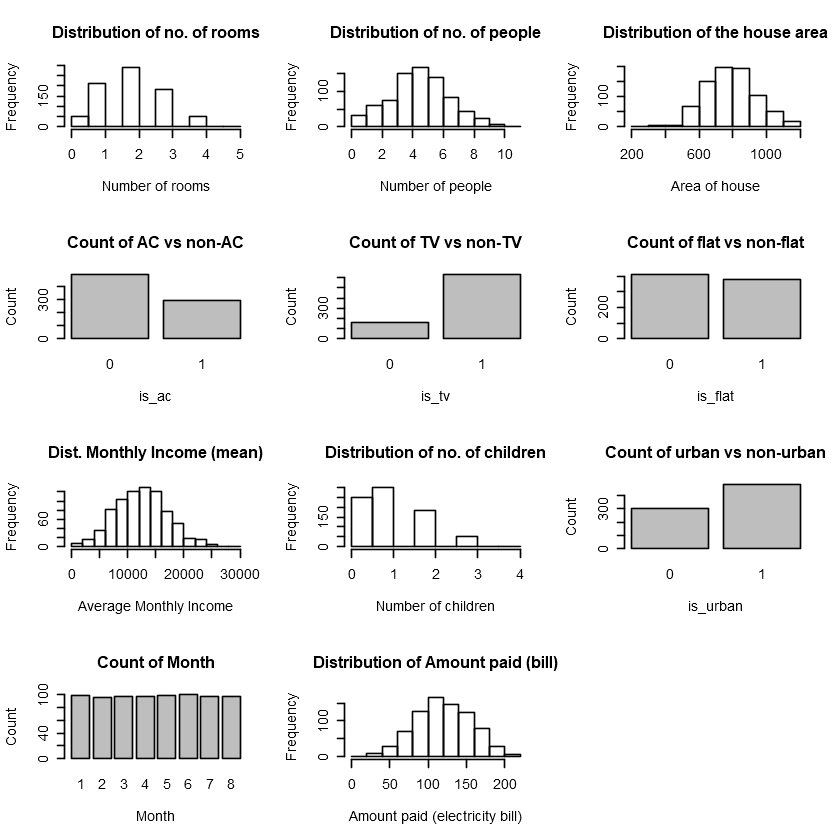

In [11]:
par(mfrow = c(4, 3))
hist(train.data$num_rooms, xlab = "Number of rooms", main = "Distribution of no. of rooms")
hist(train.data$num_people, xlab = "Number of people", main = "Distribution of no. of people")
hist(train.data$housearea, xlab = "Area of house", main = "Distribution of the house area")
barplot(table(train.data$is_ac), xlab = "is_ac", ylab = "Count", main = "Count of AC vs non-AC")
barplot(table(train.data$is_tv), xlab = "is_tv", ylab = "Count", main = "Count of TV vs non-TV")
barplot(table(train.data$is_flat), xlab = "is_flat", ylab = "Count", main = "Count of flat vs non-flat")
hist(train.data$ave_monthly_income, xlab = "Average Monthly Income", main = "Dist. Monthly Income (mean)")
hist(train.data$num_children, xlab = "Number of children", main = "Distribution of no. of children")
barplot(table(train.data$is_urban), xlab = "is_urban", ylab = "Count", main = "Count of urban vs non-urban")
barplot(table(train.data$month), xlab = "Month", ylab = "Count", main = "Count of Month")
hist(train.data$amount_paid, xlab = "Amount paid (electricity bill)", main = "Distribution of Amount paid (bill)")

The histograms of variables '`num_people`', '`housearea`', '`ave_monthly_income`', '`amount_paid`', '`num_rooms`' all look like they're following a normal distribution. For variables '`is_urban`', '`is_ac`', '`is_tv`', '`is_flat`' and '`month`' barplots have been used to represent frequencies. The barplots illustrating frequencies of the '`month`' and the '`is_flat`' variables show that there isn't really any kind of imbalance in the dataset. For variables '`is_urban`' and '`is_ac`' there is a class that has more records than the other. But the imbalance is much greater for the '`is_tv`' barplot. There is a bit skewness (positive / right skewness) for the distribution of '`num_children`' .

We'll next look at the following plots:
- corrplot: to check for the correlations between the variables - helps with observing linearity in the data
- pairs plot: to visualise these (above) relationships - especially to visualise if there's any linearity / non-linearity present.

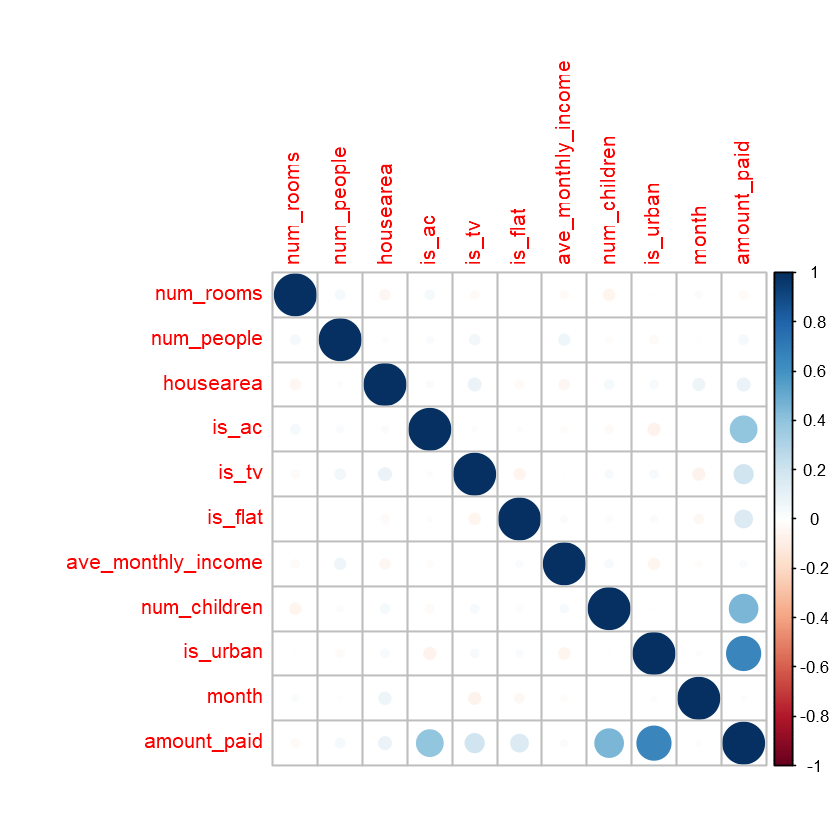

In [12]:
corrplot(round(cor(train.data), 2), method = "circle") 

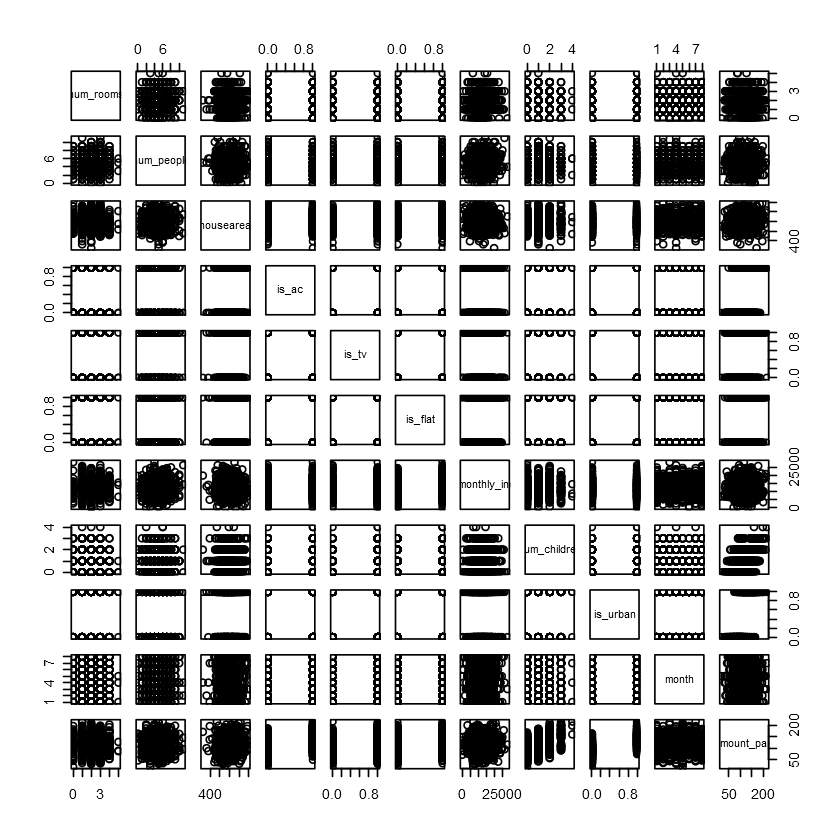

In [13]:
pairs(train.data)

As per the corrplot, there isn't any correlation amongst the predictor variables. However, there seems to be some correlation between some of the predictor variables and the response variable as follows:
- a positive strong correlation between '`is_urban`' and '`amount_paid`'.
- a positive moderate correlation between '`is_ac`', '`amount_paid`' as well as '`num_children`' and '`amount_paid`'.
- a positive weak correlation maybe between `is_flat`, '`amount_paid`' and between `is_tv`, '`amount_paid`'.

From the pairs plot, no non-linear relationships can be seen as for most of the scatter plots (apart from the plots that depict the relationships discussed above), the datapoints look randomly scattered, not really following any sort of a pattern/trend.

Given that there isn't any correlation between the predictors '`num_people`' and '`num_children`', it can be concluded that they're two different variables, which implies '`num_people`' does not include the count of the number of children in a household. If that were the case, collinearity would exist and hence one of these predictors will have to be dropped. But since that isn't the case, these two individual predictors will have an affect of their own on the response variable.

Given the results of the corrplot, we'll examine these relationships below (using Bivariate plots).

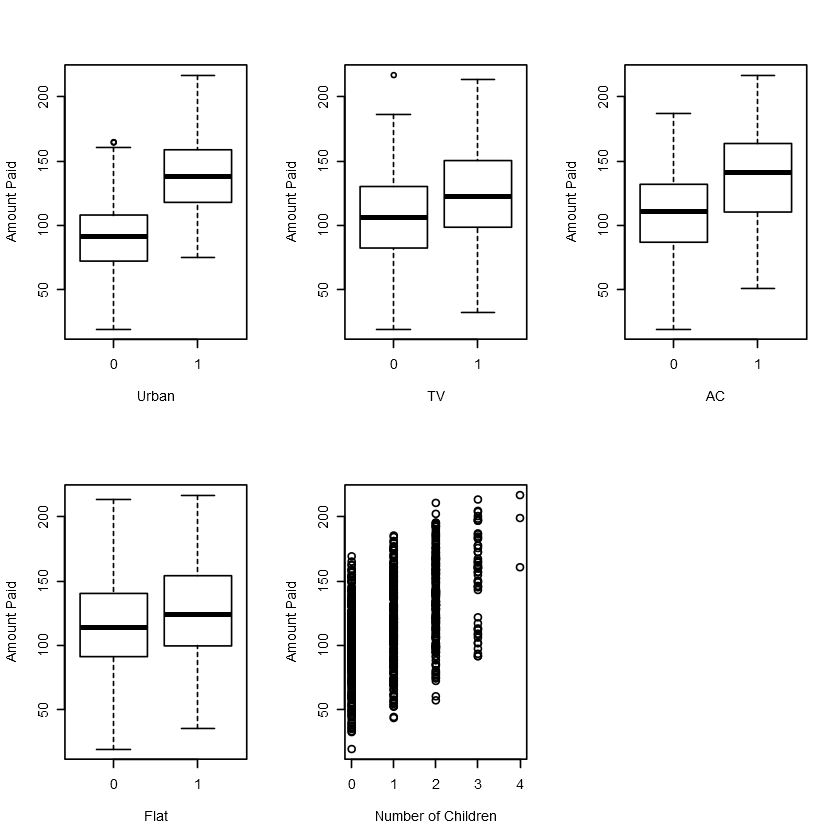

In [14]:
par(mfrow = c(2, 3))
boxplot(amount_paid ~ is_urban, data = train.data, xlab = "Urban", ylab = "Amount Paid")
boxplot(amount_paid ~ is_tv, data = train.data, xlab = "TV", ylab = "Amount Paid")
boxplot(amount_paid ~ is_ac, data = train.data, xlab = "AC", ylab = "Amount Paid")
boxplot(amount_paid ~ is_flat, data = train.data, xlab = "Flat", ylab = "Amount Paid")
plot(amount_paid ~ num_children, data = train.data, xlab = "Number of Children", ylab = "Amount Paid")

A very pronounced relatioship exists between '`amount_paid`' and '`is_urban`'. The relationship is quite strong, where the medians and means for both the discrete values (0 and 1) in this variable are also quite different and this also happens to be the case in the '`is_ac`' variable. The others don't exhibit such strong relatioships, but they definitely are linear and exist.

Given these relationships, we'll try combining the effects of all these variables together and check what the relationship of this combined effect looks like with the response variable '`amount_paid`'.

We'll create a temporary copy of the training set and create another variable called '`category`' to represent each kind of a combination of the predictors '`is_urban`', '`is_ac`', '`is_tv`' and '`is_flat`' and use a boxplot to examine the results.

In [15]:
train <- train.data #copying and storing actual training set
train$category <- "none" #addition of a new variable 

train[train$is_urban == 0 & train$is_tv == 0 & train$is_ac == 0 & train$is_flat == 0, ]$category <- "0"
train[train$is_urban == 0 & train$is_tv == 0 & train$is_ac == 0 & train$is_flat == 1, ]$category <- "1"
train[train$is_urban == 0 & train$is_tv == 0 & train$is_ac == 1 & train$is_flat == 0, ]$category <- "2"
train[train$is_urban == 0 & train$is_tv == 0 & train$is_ac == 1 & train$is_flat == 1, ]$category <- "3"

train[train$is_urban == 0 & train$is_tv == 1 & train$is_ac == 0 & train$is_flat == 0, ]$category <- "4"
train[train$is_urban == 0 & train$is_tv == 1 & train$is_ac == 0 & train$is_flat == 1, ]$category <- "5"
train[train$is_urban == 0 & train$is_tv == 1 & train$is_ac == 1 & train$is_flat == 0, ]$category <- "6"
train[train$is_urban == 0 & train$is_tv == 1 & train$is_ac == 1 & train$is_flat == 1, ]$category <- "7"

train[train$is_urban == 1 & train$is_tv == 0 & train$is_ac == 0 & train$is_flat == 0, ]$category <- "8"
train[train$is_urban == 1 & train$is_tv == 0 & train$is_ac == 0 & train$is_flat == 1, ]$category <- "9"
train[train$is_urban == 1 & train$is_tv == 0 & train$is_ac == 1 & train$is_flat == 0, ]$category <- "10"
train[train$is_urban == 1 & train$is_tv == 0 & train$is_ac == 1 & train$is_flat == 1, ]$category <- "11"

train[train$is_urban == 1 & train$is_tv == 1 & train$is_ac == 0 & train$is_flat == 0, ]$category <- "12"
train[train$is_urban == 1 & train$is_tv == 1 & train$is_ac == 0 & train$is_flat == 1, ]$category <- "13"
train[train$is_urban == 1 & train$is_tv == 1 & train$is_ac == 1 & train$is_flat == 0, ]$category <- "14"
train[train$is_urban == 1 & train$is_tv == 1 & train$is_ac == 1 & train$is_flat == 1, ]$category <- "15"

train$category <- as.numeric(train$category) #converting the 'category' variable to a discrete variable (numeric)

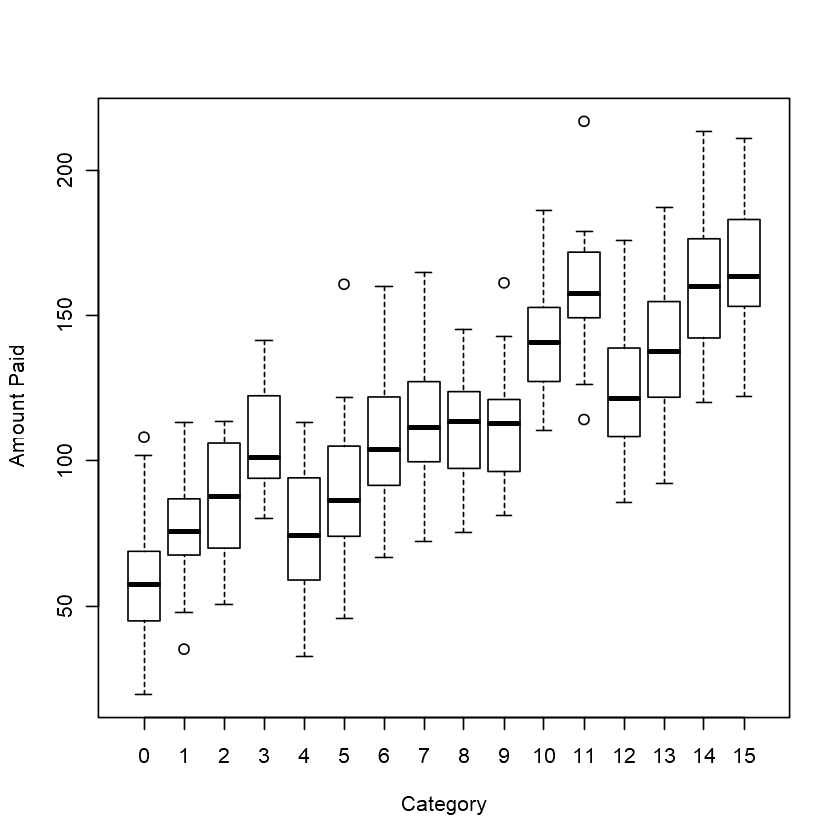

In [16]:
boxplot(amount_paid ~ category, train, xlab = "Category", ylab = "Amount Paid")

In [17]:
#Checking for correlation
cor.test(train$category, train$amount_paid)


	Pearson's product-moment correlation

data:  train$category and train$amount_paid
t = 32.487, df = 784, p-value < 2.2e-16
alternative hypothesis: true correlation is not equal to 0
95 percent confidence interval:
 0.7260051 0.7857842
sample estimates:
      cor 
0.7574779 


Indeed, a strong positive linear relationship exists, as confirmed by the result of the correlation test above as well. The p-value is less than 0.05 and so this correlation is statistically significant.

Given this linear relationship and the response variable being continuous, we'll build a Multiple Linear Regression model and see how our model performs.

### B. Model Development and Model Selection<a class="anchor" id="sec_4"></a>

Initially, we'll build a full model (a model that includes all the predictors) and assess the model's performance on both the training and test sets using the metric RMSE (Root Mean Squared Error).

In [18]:
#Multiple Linear Regression (MLR) model built using all predictors
full.fit <- lm(amount_paid ~ ., data = train.data)
summary(full.fit)


Call:
lm(formula = amount_paid ~ ., data = train.data)

Residuals:
     Min       1Q   Median       3Q      Max 
-24.7416 -10.6600   0.0505   9.6692  25.4156 

Coefficients:
                     Estimate Std. Error t value Pr(>|t|)    
(Intercept)         2.630e+01  3.403e+00   7.729 3.37e-14 ***
num_rooms          -2.046e-01  4.415e-01  -0.464 0.643128    
num_people          8.820e-01  2.264e-01   3.896 0.000106 ***
housearea           5.947e-03  3.042e-03   1.955 0.050974 .  
is_ac               3.331e+01  9.243e-01  36.039  < 2e-16 ***
is_tv               1.444e+01  1.126e+00  12.820  < 2e-16 ***
is_flat             1.163e+01  8.954e-01  12.988  < 2e-16 ***
ave_monthly_income  3.633e-04  9.553e-05   3.803 0.000154 ***
num_children        1.821e+01  4.872e-01  37.370  < 2e-16 ***
is_urban            5.010e+01  9.196e-01  54.476  < 2e-16 ***
month               2.182e-01  1.960e-01   1.113 0.265881    
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Residual stan

In [19]:
rmse(predict(full.fit, subset(train.data, select = -c(amount_paid))), train.data$amount_paid) #predictions for the training set
rmse(predict(full.fit, subset(test.data, select = -c(amount_paid))), test.data$amount_paid) #predictions for the test set

[1] 12.40741

[1] 13.14704

The full MLR model suggests that the predictors '`num_rooms`', '`housearea`' and '`month`' are not really associated with the response variable (according to their respective high p-values for significance level < 0).

We'll consider variable selection next to select possibly a subset of predictors so that we can remove any insignificant predictors (apart from the ones identified above or to verify maybe the same ones are really indeed). The following few cells will show implementation of the best subset selection method. We'll compare and check whether the chosen predictors across various metrics (Mallow's Cp, BIC, Adjusted R^2) are the same or not.

In [20]:
#Implementation of the Best Subset Selection method
regfit.full <- regsubsets(amount_paid ~ ., data = train.data, nvmax = 10)
reg.summary <- summary(regfit.full)
reg.summary

Subset selection object
Call: regsubsets.formula(amount_paid ~ ., data = train.data, nvmax = 10)
10 Variables  (and intercept)
                   Forced in Forced out
num_rooms              FALSE      FALSE
num_people             FALSE      FALSE
housearea              FALSE      FALSE
is_ac                  FALSE      FALSE
is_tv                  FALSE      FALSE
is_flat                FALSE      FALSE
ave_monthly_income     FALSE      FALSE
num_children           FALSE      FALSE
is_urban               FALSE      FALSE
month                  FALSE      FALSE
1 subsets of each size up to 10
Selection Algorithm: exhaustive
          num_rooms num_people housearea is_ac is_tv is_flat ave_monthly_income
1  ( 1 )  " "       " "        " "       " "   " "   " "     " "               
2  ( 1 )  " "       " "        " "       " "   " "   " "     " "               
3  ( 1 )  " "       " "        " "       "*"   " "   " "     " "               
4  ( 1 )  " "       " "        " "       "*"   "*

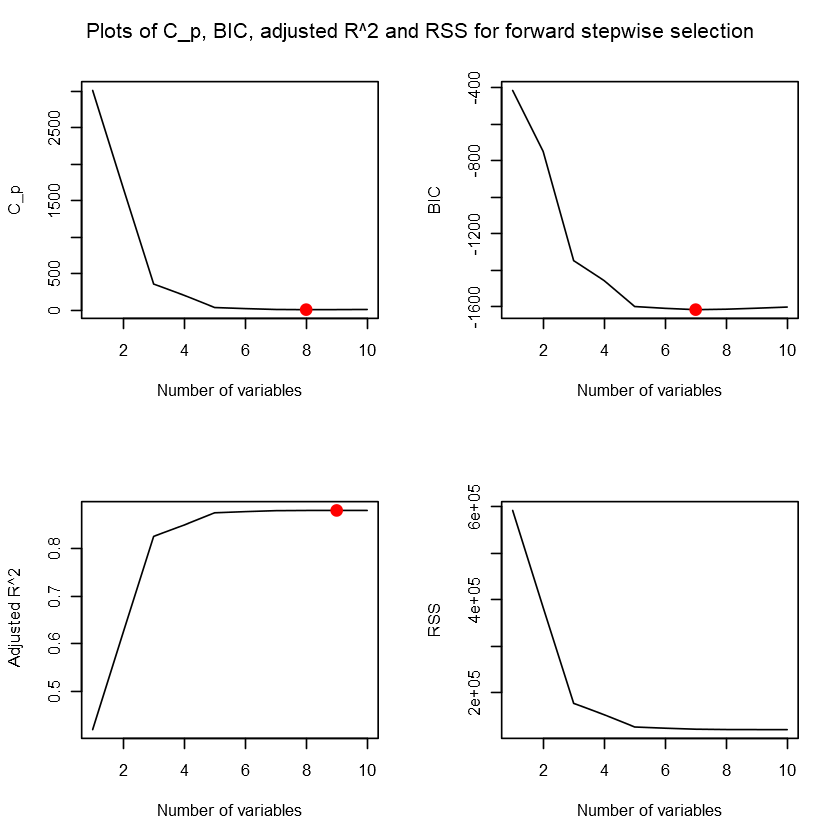

In [21]:
par(mfrow = c(2, 2))
plot(reg.summary$cp, xlab = "Number of variables", ylab = "C_p", type = "l")
points(which.min(reg.summary$cp), reg.summary$cp[which.min(reg.summary$cp)], col = "red", cex = 2, pch = 20)
plot(reg.summary$bic, xlab = "Number of variables", ylab = "BIC", type = "l")
points(which.min(reg.summary$bic), reg.summary$bic[which.min(reg.summary$bic)], col = "red", cex = 2, pch = 20)
plot(reg.summary$adjr2, xlab = "Number of variables", ylab = "Adjusted R^2", type = "l")
points(which.max(reg.summary$adjr2), reg.summary$adjr2[which.max(reg.summary$adjr2)], col = "red", cex = 2, pch = 20)
plot(reg.summary$rss, xlab = "Number of variables", ylab = "RSS", type = "l")
mtext("Plots of C_p, BIC, adjusted R^2 and RSS for forward stepwise selection", side = 3, line = -2, outer = TRUE)

The number of predictors suggested by each one of the metrics is different. We haven't considered the RSS becasue this is a result of a model with low training error and we want to ensure that the model generalizes well. However, there's a sharp fall in the RSS for predictors = 3 and it drops further when the number of predictors is 5, after which the reduction in value is not very significant. 

We'll therefore use Cross-Validation with 10 folds to assess the performance of various MLR models starting with number of predictor variables equal to 5 upto the full model (all 10 predictor variables).

In [22]:
#function that implements Cross Validation technique for MLR
cv.MLR <- function(train.data, K){
    
    ctrl <- trainControl(method = "cv", number = K)

    model.5 <- train(amount_paid ~ is_urban + num_children + is_ac + is_tv + is_flat, data = train.data, method = "lm", trControl = ctrl)
    model.6 <- train(amount_paid ~ is_urban + num_children + is_ac + is_tv + is_flat + num_people, data = train.data, method = "lm", trControl = ctrl)
    model.7 <- train(amount_paid ~ is_urban + num_children + is_ac + is_tv + is_flat + num_people + ave_monthly_income, data = train.data, method = "lm", trControl = ctrl)
    model.8 <- train(amount_paid ~ is_urban + num_children + is_ac + is_tv + is_flat + num_people + ave_monthly_income + housearea , data = train.data, method = "lm", trControl = ctrl)
    model.9 <- train(amount_paid ~ is_urban + num_children + is_ac + is_tv + is_flat + num_people + ave_monthly_income + housearea + month, data = train.data, method = "lm", trControl = ctrl)
    model.10 <- train(amount_paid ~ ., data = train.data, method = "lm", trControl = ctrl)
    
    model.5.RMSE <- colMeans(model.5$resample["RMSE"]) #RMSE of the model trained with 5 predictors using cross validation
    model.6.RMSE <- colMeans(model.6$resample["RMSE"]) #RMSE of the model trained with 6 predictors using cross validation
    model.7.RMSE <- colMeans(model.7$resample["RMSE"]) #RMSE of the model trained with 7 predictors using cross validation
    model.8.RMSE <- colMeans(model.8$resample["RMSE"]) #RMSE of the model trained with 8 predictors using cross validation
    model.9.RMSE <- colMeans(model.9$resample["RMSE"]) #RMSE of the model trained with 9 predictors using cross validation
    model.10.RMSE <- colMeans(model.10$resample["RMSE"]) #RMSE of the model trained with all predictors using cross validation
    
    model.5.se <- sqrt(var(model.5$resample["RMSE"]))[1, ] / sqrt(K) #Standard error of the model trained using 5 predictors using cross validation
    model.6.se <- sqrt(var(model.6$resample["RMSE"]))[1, ] / sqrt(K) #Standard error of the model trained using 6 predictors using cross validation
    model.7.se <- sqrt(var(model.7$resample["RMSE"]))[1, ] / sqrt(K) #Standard error of the model trained using 7 predictors using cross validation
    model.8.se <- sqrt(var(model.8$resample["RMSE"]))[1, ] / sqrt(K) #Standard error of the model trained using 8 predictors using cross validation
    model.9.se <- sqrt(var(model.9$resample["RMSE"]))[1, ] / sqrt(K) #Standard error of the model trained using 9 predictors using cross validation
    model.10.se <- sqrt(var(model.10$resample["RMSE"]))[1, ] / sqrt(K) #Standard error of the model trained using 10 predictors using cross validation
    
    
    mean.RMSE <- c(model.5.RMSE, model.6.RMSE, model.7.RMSE, model.8.RMSE, model.9.RMSE, model.10.RMSE)
    SE <- c(model.5.se, model.6.se, model.7.se, model.8.se, model.9.se, model.10.se)

    predictors <- seq(5, 10)
    
    #dataframe that'll store the RMSE and SE for each model trained with p predictors 
    df <- data.frame(predictors = predictors, mean.RMSE = mean.RMSE, SE = SE)
    
    return(df)
    
}

In [23]:
seeds <- seq(9, 90, 5) #seeds to consider for performing 10-fold CV multiple times
final_results <- data.frame() #dataframe that'll store results of 10-fold CV performed for each seed

#perform 10-fold CV for each seed
for(seed in seeds){
    
    set.seed(seed)
    result <- cv.MLR(train.data, 10)
    final_results <- rbind(final_results, result)
    
}

In [24]:
#grouping the results obtained above as per the number of predictors to compute average RMSE and SE (average of all seeds)
grouped <- final_results %>% group_by(predictors)
new.grouped <- grouped %>% summarise(avg.RMSE = mean(mean.RMSE), avg.SE = mean(SE))

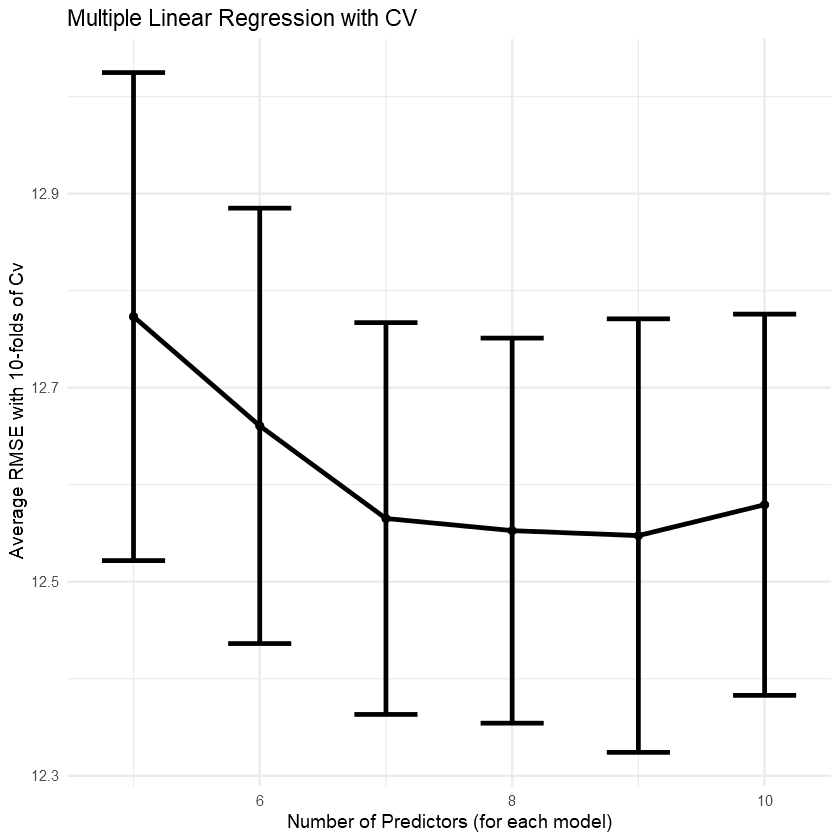

In [25]:
#plot that draws an geom_errorbar() to depict the SE followed by plotting the average RMSE for each model with p predictors
ggplot(new.grouped, aes(x = predictors, y = avg.RMSE)) +
geom_errorbar(aes(ymin = avg.RMSE - avg.SE, ymax = avg.RMSE + avg.SE), width = 0.5, position = position_dodge(0.5), size = 1) +
geom_line(position = position_dodge(0.5), size = 1) + theme_minimal() +
geom_point(position = position_dodge(0.5)) + 
labs(x = "Number of Predictors (for each model)", y = "Average RMSE with 10-folds of Cv", title = 'Multiple Linear Regression with CV')

The plot above suggests that the average RMSE across 10 folds for 10 different seeds is the lowest for a model trained with 9 predictors. But if we make use of the one-standard-error rule, the most parsimonious model with low error that falls within 1 standard deviation of the minimum (predictors = 9) CV error is the model with 7 predictors. This model happens to pick the same significant predictors that were observed earlier from the full MLR model.

It can be seen that the mean RMSE for all these models are pretty close, and therefore, we can conclude that these set of models appear to be more or less equally good and hence that's why we've chosen a simpler model using the one-standard-error rule. Moreover, when we perform repeated cross-validation, the split in the train and validation sets differ, so averaging the results of the model performance can avoid any surprises and help get a better understanding of the performance. 

We'll now look at the MLR model that will be built using the 7 most important predictors and assess its performance using RMSE for both sets.

In [26]:
#Fitting of the Multiple Linear Regression final model
final.model <- lm(amount_paid ~ is_urban + num_children + is_ac + is_tv + is_flat + num_people + ave_monthly_income, data = train.data)
summary(final.model)


Call:
lm(formula = amount_paid ~ is_urban + num_children + is_ac + 
    is_tv + is_flat + num_people + ave_monthly_income, data = train.data)

Residuals:
     Min       1Q   Median       3Q      Max 
-25.0657 -10.6333  -0.0748   9.9594  25.8901 

Coefficients:
                    Estimate Std. Error t value Pr(>|t|)    
(Intercept)        3.157e+01  2.101e+00  15.028  < 2e-16 ***
is_urban           5.016e+01  9.208e-01  54.474  < 2e-16 ***
num_children       1.826e+01  4.869e-01  37.503  < 2e-16 ***
is_ac              3.334e+01  9.251e-01  36.037  < 2e-16 ***
is_tv              1.453e+01  1.121e+00  12.968  < 2e-16 ***
is_flat            1.155e+01  8.955e-01  12.895  < 2e-16 ***
num_people         8.792e-01  2.265e-01   3.882 0.000113 ***
ave_monthly_income 3.545e-04  9.553e-05   3.710 0.000222 ***
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Residual standard error: 12.52 on 778 degrees of freedom
Multiple R-squared:  0.8806,	Adjusted R-squared:  0.8795 
F-stat

In [27]:
rmse(predict(final.model, subset(train.data, select = -c(amount_paid))), train.data$amount_paid) #predictions for the training set
rmse(predict(final.model, subset(test.data, select = -c(amount_paid))), test.data$amount_paid) #predictions for the test set

[1] 12.45282

[1] 13.25048

Even though the model gives a slightly higher value for the test RMSE (as well as training RMSE) when compared to the full model, we've seen from the 10-fold cross validation results above that the average RMSE for 7-predictor MLR model is better than the full model. Therefore, by choosing only 7 predictors we've reduced the complexity of the model and also ensure that the model generalises well. This is also supported by the RSS plot from the Best Subset Selection method above. The variance explained by the first 5 predictors is pretty impressive and then the addition of the next two predictors shows a small improvement in the amount of variance explained. After that, the addition of more predictors does not have a very significant effect. With the cross-validation implementation above, we were able to validate our model with more data which helped us in understanding the consistency of each model on unseen data. 

In [28]:
anova(final.model, full.fit)

Res.Df,RSS,Df,Sum of Sq,F,Pr(>F)
778,121887.3,NA,NA,NA,NA
775,120999.8,3,887.4431,1.894682,0.1289871


To further support the results above: The ANOVA test above between the '`final.model`' with 7 predictors and the model built and trained using the complete set of predictors (i.e all 10) '`full.fit`' shows that the inclusion of the extra predictors is not statistically significant (based on the p-value of 0.129 for the assumption that the significance level: less than 0.05). Also, the improvement in the RSS is very small too. 

We'll perform further tests below to check for any outliers or high leverage/influential points. We'll also check for multicollinearity with the variance inflation factor. 

In [29]:
#Checking for Leverage Points
hats <- as.data.frame(hatvalues(final.model)) #calculating leverage for each observation
leverage <- hats[order(-hats['hatvalues(final.model)']), ] #sorting observations based on their leverage values - descending order
sum(leverage > (7 + 1 / dim(train.data)[1])) #checking for the number of leverage points greater than the given threshold -> (p + 1 / n)

[1] 0

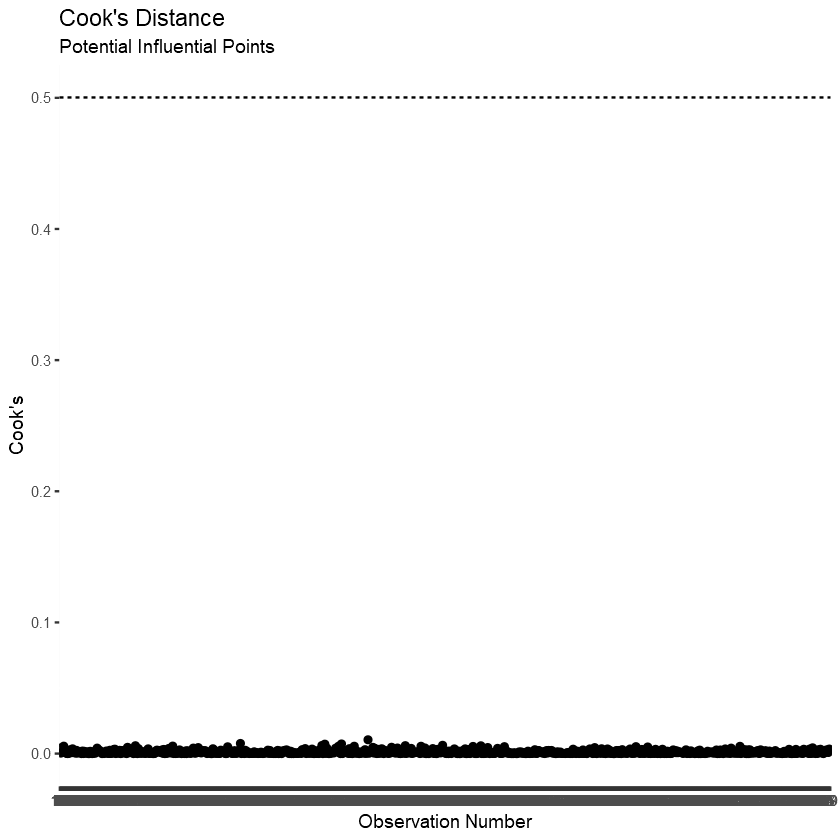

In [30]:
#Checking and visualising for Influential Points
cooks_crit = 0.5
cooks <- cooks.distance(final.model) #calculating Cook's distance for each observation
df <- data.frame(obs = names(cooks), #dataframe to store the Cook's distance for each observation
                 cooks = cooks)
ggplot(df, aes(y = cooks, x = obs)) +
  geom_point() +
  geom_hline(yintercept = cooks_crit, linetype = "dashed") +
  labs(title = "Cook's Distance",
       subtitle = "Potential Influential Points",
       x = "Observation Number",
       y = "Cook's")

In [31]:
#Checking for outliers
outlierTest(final.model, cutoff = 0.05, digits = 1)

No Studentized residuals with Bonferonni p < 0.05
Largest |rstudent|:
    rstudent unadjusted p-value Bonferonni p
250 2.077966            0.03804           NA

The tests above infer that we do not have any outliers (indicated by the "no studentized residuals" message) or high leverage/influential points.

In [32]:
#Checking for multicollinearity
vif(final.model)

is_urban       num_children              is_ac              is_tv 
          1.010173           1.003442           1.006573           1.007222 
           is_flat         num_people ave_monthly_income 
          1.004245           1.007906           1.008925

There is no multicollinearity present as the values above are all close to 1, which implies no correlation.

## 3. Results and Discussion<a class="anchor" id="sec_5"></a>

In the following few cells we'll look at our final model and interpret the results.

In [33]:
summary(final.model)


Call:
lm(formula = amount_paid ~ is_urban + num_children + is_ac + 
    is_tv + is_flat + num_people + ave_monthly_income, data = train.data)

Residuals:
     Min       1Q   Median       3Q      Max 
-25.0657 -10.6333  -0.0748   9.9594  25.8901 

Coefficients:
                    Estimate Std. Error t value Pr(>|t|)    
(Intercept)        3.157e+01  2.101e+00  15.028  < 2e-16 ***
is_urban           5.016e+01  9.208e-01  54.474  < 2e-16 ***
num_children       1.826e+01  4.869e-01  37.503  < 2e-16 ***
is_ac              3.334e+01  9.251e-01  36.037  < 2e-16 ***
is_tv              1.453e+01  1.121e+00  12.968  < 2e-16 ***
is_flat            1.155e+01  8.955e-01  12.895  < 2e-16 ***
num_people         8.792e-01  2.265e-01   3.882 0.000113 ***
ave_monthly_income 3.545e-04  9.553e-05   3.710 0.000222 ***
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Residual standard error: 12.52 on 778 degrees of freedom
Multiple R-squared:  0.8806,	Adjusted R-squared:  0.8795 
F-stat

The F-statistic value and the associated p-value suggests that this MLR model provides a better fit to the training set than a model with no predictor variables would (i.e, a null model) - meaning at least one the predictors is associated with the response variable.

The estimate for the Intercept is the value our model would predict when all the coefficients are 0, i.e the expected value of our prediction when all predictors take the value 0 is 31.57, the average expected amount to be paid (though it may seem unreasonable for all the predictors to be 0 for the intercept estimate to be meaningful - in this case the intercept term here only guides in placing the regression line at the right place).
The coefficients provide the amount of change in our response variable '`amount_paid`' for a unit change in each of the predictor variable, keeping the others constant. 
For the continuous predictors:
- a unit change in the '`ave_monthly_income`' is associated with an increase of 0.00035 in currency (for instance, AUD) for the amount to be paid for electricity.

For the discrete binary variables:
- properties/houses where'`is_urban`' takes the value of 1 pay 50.16 AUD more for electricity than those who do not reside in an urban property.
- properties/houses where'`is_ac`' takes the value of 1 pay 33.34 AUD more for electricity than those who do not have an air conditioner.
- properties/houses where'`is_tv`' takes the value of 1 pay 14.53 AUD more for electricity than those who do not have a television.
- properties/houses where'`is_flat`' takes the value of 1 pay 11.55 AUD more for electricity than those who do not reside in a flat/apartment.

For the remaining discrete variables:
- for the '`num_children`' predictor when comparing two households/families, the one with another kid (difference in the number of children between the families is 1) is expected to pay 18.26 AUD more.
- for the '`num_people`' predictor when comparing two households/families, the one with another family member/extra person (difference in the number of people between the households is 1) is expected to pay 0.88 AUD more.



All the p-values are small indicating that there is a significant relationship between each predictor and the response variable. The R2 value suggests that about 88% of the variation in the response variable is explained by the predictors. The adjusted R^2 value is pretty high too.

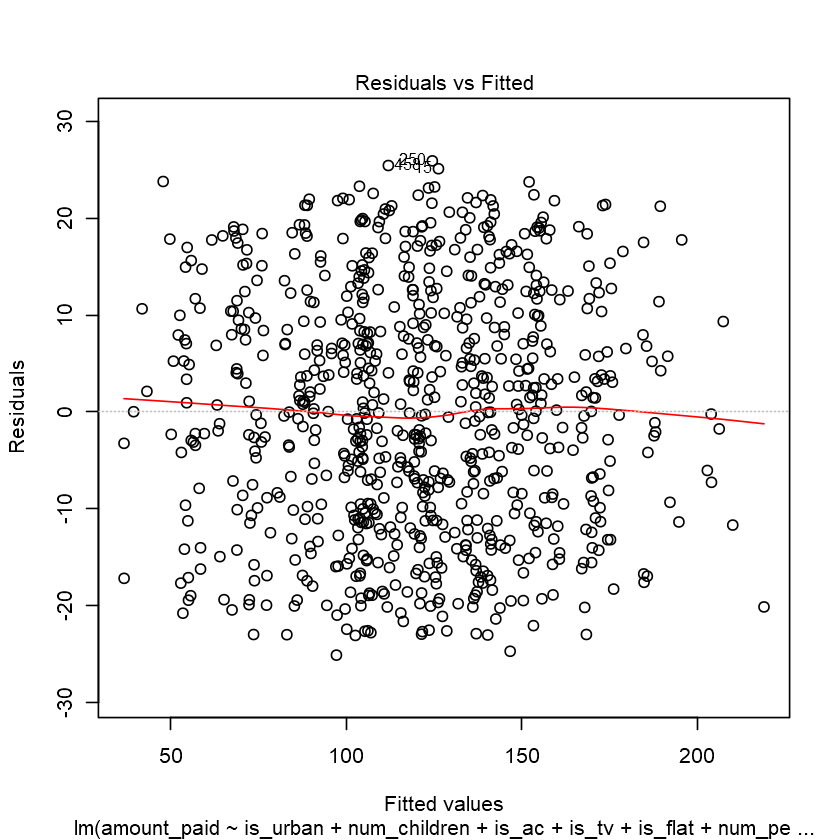

In [34]:
plot(final.model, which = 1) #Residuals PLot

The random scatter in the plot above helps establish the fact that the relationship between the variables is indeed linear. (also Homoscedasticity - constant variance of error terms).

The set of attributes that may have a greater significant impact on the response variable should be the variables '`is_urban`', '`num_children`', '`is_ac`', '`is_tv`' and '`is_flat`'. To confirm this, let's consider the following points:
- From the EDA above, we've seen that the correlation between these predictors and the response variable is either strong or moderate. We even had a look at the combined effect of 4 of these.
- The Best Subset Selection method above suggests the same result for a model with 5 (best) predictors. This is also supported by the graphs obtained with the metrics Mallow's Cp, BIC, Adjusted R^2 and RSS - the sharp decrease the plots of Mallow's Cp, BIC and RSS and the sharp increase in the Adjusted R^2 plot.
- The Standard Error estimates (from the regression summary table above), for all parameters, is smaller than the corresponding
Coefficient estimate, indicating that the Coefficient will not be taking a value of 0 (indication of an association).

To confirm the above, we'll build a MLR model using these predictors and have a look at the variance explained by the addition of these predictors, one by one.

In [35]:
#The order for the selection of predictors is based upon the results of the best subset selection method discussed above

#Model building with p predictors, where p = 1, 2, ..., 5
m1 <- lm(amount_paid ~ is_urban, data = train.data)
m2 <- lm(amount_paid ~ is_urban + num_children, data = train.data)
m3 <- lm(amount_paid ~ is_urban + num_children + is_ac, data = train.data)
m4 <- lm(amount_paid ~ is_urban + num_children + is_ac + is_tv, data = train.data)
m5 <- lm(amount_paid ~ is_urban + num_children + is_ac + is_tv + is_flat, data = train.data)

#Adjusted R^2 value for each model trained above
summary(m1)$adj.r.squared
summary(m2)$adj.r.squared
summary(m3)$adj.r.squared
summary(m4)$adj.r.squared
summary(m5)$adj.r.squared

[1] 0.418966

[1] 0.6231816

[1] 0.8254447

[1] 0.8492606

[1] 0.87508

These five predictors together explain about 87.5% variation already in the response variable. Even the p-values of the final model suggest that these are statistically significant predictors.

- The '`is_urban`' represents whether a property/house is present in an urban area or not. It is possible that the houses in an urban area tend to pay higher bills due to other factors like cost to deliver power, even if the electricity price is the same. Non urban properties may be facing issues with respect to access or the architecture used for electricity delivery, etc.
- The '`num_children`' represents the number of children in the house. These children may be smaller kids or teenagers. With teenagers who may use electricity for their purposes, including entertainment/study, it is possible for families/households to pay higher bills on an average than those without.
- The '`is_ac`' represents the presence of an air conditioner. Now, if these ACs happen to be reverse-cycle AC, then they're capable of both heating and cooling. For the Australian climate and weather, these devices do tend to run very frequently, which implies higher consumption of power resulting in higher bills.
- The '`is_tv`' represents the presence of a TV. Again, TV is used for entertainment by everyone. The more the usage, the more consumption of power and hence higher bills.
- The '`is_flat`' represents if the property/house happens to be a flat or apartment. It is possible for people/families residing in such properties to also pay for electricity consumed in common areas meant for all the residents in the community apart from their individual bills, hence higher bills paid in total.

The final model also suggests two other variables that have a slight impact on the response variable, these include:
- '`num_people`': More people in the house means more electricity maybe consumed for various purposes.
- '`ave_monthly_income`': More the income is, more one can afford to spend on electricity consumption.

(The presence of appliances like ACs and TVs can cause high bills also due to other factors such as ageing or any overdue maintenance, meaning they may not be energy efficient even if the usage is low. Lifestyle plays a major role too).

Even though the 5 predictors explain most of the variance in the response variable together, the addition of the other two variables is an improvement, thereby improving the amount of variance explained (as seen in from the results of cross validation too). This is confirmed by the ANOVA test below:

In [36]:
anova(m5, final.model)

Res.Df,RSS,Df,Sum of Sq,F,Pr(>F)
780,126700.2,NA,NA,NA,NA
778,121887.3,2,4812.891,15.36021,2.867347e-07


There is a significant fall in the RSS value. Also, the p-value suggests that the difference between the two models is statistically significant, implying the addition of the two predictors has an effect on the response variable.

The final model's prediction for the amount to be paid for a given observation will deviate from the true regression line by an average of about 12.52 units/AUD. That is, even if the true model's coefficients are known, the prediction would still be off by about 12.52 units on an average. Our training set is a sample drawn from the true population, then the mean of the sample would be an unbiased estimate of the true population mean. Therefore, the percentage error (Residual Standard Error / Mean) is given below:

In [37]:
(summary(final.model)$sigma / mean(train.data$amount_paid)) * 100 #Percentage error in prediction

[1] 10.4223

The amount of variability in the '`amount_paid`' - the response variable, by these set of predictors is about 88%, which implies a large proportion (0.88 is close to 1) of the variability has been explained, as shown below:

In [38]:
summary(final.model)$r.sq #R^2 value of the final model

[1] 0.8805907

## 4. Conclusion<a class="anchor" id="sec_6"></a>

We've identified the key factors that may be strongly associated with the response variable '`amount_paid`' - the monthly electricity bill. We've used these predictors to build a Multiple Linear Regression model and trained it using the training set after which we've computed the Root Mean Squared Error (RMSE) on the test set to analyze the error of the model in predictions for an unseen dataset (RMSE of test set is: 13.25). The model does a decent job in predicting the monthly electricity bill for a given set of predictors.

## 5. References<a class="anchor" id="sec_7"></a>

- Zach. (2020). How to Calculate Leverage Statistics in R. Retrieved from https://www.statology.org/leverage-in-r/
- Foley, M. (2019). How to handle influential data points. Retrieved from https://rpubs.com/mpfoley73/501093
- FIT5149 Applied Data Analysis. *Tutorial on Linear Model Selection and Regularization.* Retrieved from https://lms.monash.edu/course/view.php?id=141660&section=11